# Reversed MC RAPTOR

## Left out at this stage:

- Realistic time to get out of one transport and walk to the platform of the next. Instead, we just set it to 2 minutes, no matter what.

## Encoding the data structures
### General considerations
We adhere to the data structures proposed by Delling et al. These structures aim to minimize read times in memory by making use of consecutive in-memory adresses. Thus, structures with varying dimensions (e.g dataframes, python lists) are excluded. We illustrate the difficulty with an example. 

Each route has a potentially unique number of stops. Therefore, we cannot store stops in a 2D array of routes by stops, as the number of stops is not the same for each route. We adress this problem by storing stops consecutively by route, and keeping track of the index of the first stop for each route.

This general strategy is applied to all the required data structures, where possible.

### routes
The `routes` array will contain arrays `[n_trips, n_stops, pt_1st_stop, pt_1st_trip]` where all four values are `int`. To avoid overcomplicating things and try to mimic pointers in python, `pt_1st_stop` and `pt_1st_trip` contain integer indices.

In [15]:
import numpy as np
import pickle

def pkload(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [16]:
routes = pkload("../data/routes_array_cyril.pkl").astype(np.uint32)
print(routes.shape)
routes

(1461, 4)


array([[     1,     26,      0,      0],
       [     1,      8,     26,     26],
       [     1,     17,     34,     34],
       ...,
       [     1,      3,  15297, 260396],
       [     2,     16,  15300, 260399],
       [     1,     28,  15316, 260431]], dtype=uint32)

### routeStops
`routeStops` is an array that contains the ordered lists of stops for each route. `pt_1st_stop` in `routes` is required to get to the first stop of the route. is itself an array that contains the sequence of stops for route $r_i$.

In [17]:
routeStops = pkload("../data/route_stops_array_cyril.pkl").astype(np.uint16)
print(routeStops.shape)
print(routeStops.max())
routeStops

(15344,)
1406


array([1221,  816,  776, ..., 1349, 1037,  552], dtype=uint16)

### stopTimes

The i-th entry in the `stopTimes` array is itself an array which contains the arrival and departure time at a particular stop for a particular trip. `stopTimes` is sorted by routes, and then by trips. We retrieve the index of the first (earliest) trip of the route with the pointer `pt_1st_trip` stored in `routes`. We may use the built-in `numpy` [date and time data structures](https://blog.finxter.com/how-to-work-with-dates-and-times-in-python/). In short, declaring dates and times is done like this: `np.datetime64('YYYY-MM-DDThh:mm')`. Entries with a `NaT` arrival or departure times correspond to beginning and end of trips respectively.

Note that trips are indexed implicitely in stopTimes, but we decided to change a little bit from the paper and index them according to their parent route instead of giving them an absolute index. It makes things a bit easier when coding the algorithm.

In [18]:
stopTimes = pkload("../data/stop_times_array_cyril.pkl")
print(stopTimes.shape)
stopTimes

(260459, 2)


array([[                          'NaT', '2020-05-23T07:00:00.000000000'],
       ['2020-05-23T07:01:00.000000000', '2020-05-23T07:01:00.000000000'],
       ['2020-05-23T07:02:00.000000000', '2020-05-23T07:02:00.000000000'],
       ...,
       ['2020-05-23T07:35:00.000000000', '2020-05-23T07:35:00.000000000'],
       ['2020-05-23T07:36:00.000000000', '2020-05-23T07:36:00.000000000'],
       ['2020-05-23T07:37:00.000000000',                           'NaT']],
      dtype='datetime64[ns]')

`NaT` is the `None` equivalent for `numpy datetime64`.

In [19]:
print(np.isnat(stopTimes[0]))

[ True False]


### stopRoutes

`stopRoutes` contains the routes (as `int`s representing an index in `routes`) associated with each stop. We need the pointer in `stops` to index `stopRoutes` correctly.

In [20]:
stopRoutes = pkload("../data/stop_routes_array_cyril.pkl").flatten().astype(np.uint32)
print(stopRoutes.shape)
stopRoutes

(15344,)


array([  17,  116,  126, ...,  861,  982, 1087], dtype=uint32)

## transfers
`transfers` is a 2D `np.ndarray` where each entry `[p_j, time]` represents (in seconds) the time it takes to walk from stop p_j to the implicitely given stop p_i.
p_i is given implicitely by the indexing, in conjunction with `stops`. In other words:
`transfers[stops[p_i][2]:stops[p_i][3]]` returns all the footpaths arriving at stop p_i.

As we cannot store different data types in numpy arras, `time` will have to be converted to `np.timedelta64`, the format used to make differences between `np.datetime.64` variables. We will consider all `time` values as **positive values in seconds**.

In [21]:
transfers = pkload("../data/transfer_array_cyril.pkl").astype(np.uint16)
print(transfers.shape)
transfers

(6264, 2)


array([[ 815,  267],
       [1350,  569],
       [  63,  470],
       ...,
       [1113,  382],
       [1122,  338],
       [1270,  553]], dtype=uint16)

## stops

`stops` stores the indices in `stopRoutes` and in `transfers` corresponding to each stop.

`stopRoutes[stops[p][0]:stops[p][1]]` returns the routes serving stop p.

`transfers[stops[p][2]:stops[p][3]]` returns the footpaths arriving at stop p.

In [26]:
stops = pkload("../data/stops_array_cyril.pkl")
print(np.isnan(stops.astype(np.float64)).sum(axis=0))
print(np.equal(stops, None).sum(axis=0))
print(stops.shape)
stops = stops[:,[0,0,1,1]]
# Make column 1 contain the start_index of the next stop in stopRoutes
stops[:-1,1] = stops[1:,0]
stops[-1, 1] = stopRoutes.shape[0]
# Make column 2 contain the start_index of the next stop in stopRoutes
for i in np.isnan(stops[:,2].astype(np.float64)).nonzero()[0]:
    stops[i,2] = stops[i-1,2]
print(np.isnan(stops.astype(np.float64)).sum(axis=0))
stops[:-1,3] = stops[1:,2]
stops[-1, 3] = transfers.shape[0]
# Convert to int
stops = stops.astype(np.uint32)
stops

[ 0 70]
[0 0]
(1407, 2)
[ 0  0  0 70]


array([[    0,    11,     0,     2],
       [   11,    20,     2,     7],
       [   20,    38,     7,    22],
       ...,
       [15303, 15334,  6242,  6250],
       [15334, 15339,  6250,  6257],
       [15339, 15344,  6257,  6264]], dtype=uint32)

### Example

In [27]:
p = 0
routes_serving_p = stopRoutes[stops[p][0]:stops[p][1]]
print("routes serving stop 0:", routes_serving_p)
for r in routes_serving_p:
    print("stops of route {}:".format(r), routeStops[routes[r][2]:routes[r][2]+routes[r][1]])
for pPrime, walking_seconds in transfers[stops[p][2]:stops[p][3]]:
    print("stop {} can be reached from stop {} by walking for {} seconds.".format(p, pPrime, walking_seconds))

routes serving stop 0: [  17  116  126  144  169  250  267  356  573  617 1054]
stops of route 17: [ 168 1365  504  434  715  454 1236  186  959   81  130  774  284  958
  815    0 1350  265  780  305  490   16  180 1397]
stops of route 116: [1397  180   16  490  305  780  265 1350    0  815  958  284  774  130
   81  959  186 1236  454]
stops of route 126: [   0 1350  265  780  490   16  180 1397]
stops of route 144: [1397  180   16  490  780  265 1350    0  815  958  284  774  130   81
  959  186 1236  454  715  434  504 1365  168]
stops of route 169: [   0 1350  265  780  305  490   16  180 1397]
stops of route 250: [   0  815  958  284  774  130   81  959  186 1236  454  715  434  504
 1365  168]
stops of route 267: [1397  180   16  490  780  265 1350    0  815  958  284  774  130   81
  959  186 1236  454]
stops of route 356: [1397  180   16  490  305  780  265 1350    0  815  958  284  774  130
   81  959  186 1236  454  715  434  504 1365  168]
stops of route 573: [ 454 1236  18

## Distribution of delays

In [28]:
import gzip 
with gzip.open("../data/join_distribution_cumulative_p_2.pkl.gz") as distrib_pkl:
    distrib_delays = pickle.load(distrib_pkl)
    
distrib_delays[0:2]

array([[0.        , 0.01501502, 0.03603604, 0.06306306, 0.09009009,
        0.12012012, 0.15015015, 0.18018018, 0.21321321, 0.24624625,
        0.27927928, 0.31231231, 0.34534535, 0.37837838, 0.41141141,
        0.44444444, 0.47747748, 0.51051051, 0.54354354, 0.57657658,
        0.60960961, 0.64264264, 0.67567568, 0.71171171, 0.74774775,
        0.78378378, 0.81981982, 0.85585586, 0.89189189, 0.92792793,
        0.96396396, 1.        ],
       [0.        , 0.01501502, 0.03603604, 0.06306306, 0.09009009,
        0.12012012, 0.15015015, 0.18018018, 0.21321321, 0.24624625,
        0.27927928, 0.31231231, 0.34534535, 0.37837838, 0.41141141,
        0.44444444, 0.47747748, 0.51051051, 0.54354354, 0.57657658,
        0.60960961, 0.64264264, 0.67567568, 0.71171171, 0.74774775,
        0.78378378, 0.81981982, 0.85585586, 0.89189189, 0.92792793,
        0.96396396, 1.        ]])

## Relate `stop_id`s and `route_id`s to the integer indices used in the algorithm

In [67]:
stop_times_df = pkload("../data/stop_times_df_cyril.pkl")[['route_id', 'stop_id_general', 'stop_name', 'route_int', 'stop_int']]
stop_times_df.head()

route_id  stop_id_general              stop_name  route_int  stop_int
0  26-13-j19-1          8576240  Zürich, Meierhofplatz          0      1221
1  26-13-j19-1          8591353        Zürich, Schwert          0       816
2  26-13-j19-1          8591039    Zürich, Alte Trotte          0       776
3  26-13-j19-1          8591121   Zürich, Eschergutweg          0       307
4  26-13-j19-1          8591417    Zürich, Waidfussweg          0       347

In [68]:
stop_ids_names = stop_times_df[['stop_id_general', 'stop_int', 'stop_name']].drop_duplicates()
assert np.all(stop_ids_names == stop_ids_names.drop_duplicates(subset='stop_int'))
assert np.all(stop_ids_names == stop_ids_names.drop_duplicates(subset='stop_id_general'))
assert np.all(stop_ids_names == stop_ids_names.drop_duplicates(subset='stop_name'))
stop_ids_names = stop_ids_names.sort_values(by='stop_int')
stop_ids = stop_ids_names['stop_id_general'].to_numpy()
stop_names = stop_ids_names['stop_name'].to_numpy()
print(stop_ids, stop_names)

[8502508 8503078 8503088 ... 8591173 8590772 8503509] ['Spreitenbach, Raiacker' 'Waldburg' 'Zürich HB SZU' ...
 'Zürich, Haldenbach' 'Rüschlikon, Belvoir' 'Schlieren']


In [69]:
p = np.random.randint(stops.shape[0])
print(p, stop_ids[p], stop_names[p])
stop_times_df[stop_times_df['stop_int'] == p].head(2)

428 8576095 Uster, Stadtpark


route_id  stop_id_general         stop_name  route_int  stop_int
5756  26-813-j19-1          8576095  Uster, Stadtpark         70       428
5764  26-813-j19-1          8576095  Uster, Stadtpark         70       428

In [15]:
r = np.random.randint(routes.shape[0])
print(r, route_ids[r])
stop_times_df[stop_times_df['route_int'] == r].head(2)

KeyError: 8

## Implementing the reversed Multiple Criteria RAPTOR

Based on modified version of RAPTOR (reversed RAPTOR), we implement a multiple criteria RAPTOR algorithm.
The optimization criteria are:
- Latest departure
- Highest probability of success of the entire trip
- Lowest number of connections (implicit with the round-based approach)

In [34]:
# absolute constants:

tau_change_platform = np.timedelta64(2, 'm')
np.datetime64('2020-05-11T15:30') - tau_change_platform

numpy.datetime64('2020-05-11T15:28')

In [35]:
# helper functions

def arr_and_dep_time(r, t, offset_p):
    """This function should not be called directly.
    Use arrival_time and departure_time.
    In particular, this function relies on "t is not None"-
    """
    return stopTimes[routes[r][3]       # 1st trip of route
                     + t * routes[r][1] # offset for the right trip
                     + offset_p         # offset for the right stop
                    ]

def arrival_time(r, t, offset_p):
    """Returns 2000 (instead of 0) if t is None.
    Otherwise, returns the arrival time of the t-th trip of route r
    at the offset_p-th stop of route r.
    trips and stops of route r start at t=0, offset_p=0.
    """
    if t is None:
        return np.datetime64('2000-01-01T01:00')
    
    return arr_and_dep_time(r,t,offset_p)[0] # 0 for arrival time

def departure_time(r, t, offset_p):
    """Throws TypeError if t is None.
    Otherwise, returns the departure time of the t-th trip of route r
    at the offset_p-th stop of route r.
    trips and stops of route r start at t=0 & offset_p=0.
    """
    if t is None:
        raise TypeError("Requested departure time of None trip!")
    
    return arr_and_dep_time(r,t,offset_p)[1] # 1 for departure time

def get_stops(r):
    """Returns the stops of route r"""
    idx_first_stop = routes[r][2]
    return routeStops[idx_first_stop:idx_first_stop+routes[r][1]] # n_stops = routes[r][1]    

In [36]:
class InstantiationException(Exception):
    pass

class BaseLabel:
    """An abstract base class for Labels. Do not instantiate.
    A label corresponds to a recursive (partial) solution, going
    to the target stop from the stop currently under consideration.
    """
    def __init__(self, stop, tau_dep, Pr):
        self.stop    = stop
        self.tau_dep = tau_dep
        self.Pr      = Pr
    
    def dominates(self, other):
        """Returns True if self dominates other, else returns False.
        other: another Label instance.
        """
        if self.tau_dep >= other.tau_dep and self.Pr >= other.Pr:
            return True
        return False
    
    def print_journey(self):
        print("Journey begins at stop {stop} at time {tau}, with an "
              "overall probability of success = {Pr} \n".format(
                  stop = self.stop,
                  tau  = self.tau_dep,
                  Pr   = self.Pr
              )
             )
        self.print_instructions()
    
    def to_str(self):
        s = "Departure at {0} from stop {1}.".format(self.tau_dep, self.stop)
        return repr(type(self)) + s
    
    def pprint(self, indent=''):
        print(indent, self.to_str())
    
    def copy(self):
        raise InstantiationException("class BaseLabel should never "
                                     "be instantiated."
                                    )

class ImmutableLabel(BaseLabel):
    """Base class for immutable Labels"""
    def copy(self):
        return self

class TargetLabel(ImmutableLabel):
    """A special type of label reserved for the target stop."""
    def __init__(self, stop, tau_dep):
        BaseLabel.__init__(self, stop, tau_dep, 1.)
        
    def print_instructions(self):
        """Finish printing instructions for the journey."""
        print("You have arrived at the target stop {stopN} ({stopI}) "
              "before the target time of {tau}.".format(
                  stopN=stop_names[self.stop],
                  stopI=stop_ids[self.stop],
                  tau=self.tau_dep
              ))

class WalkLabel(ImmutableLabel):
    """A special type of label for walking connections."""
    def __init__(self, stop, tau_walk, next_label):
        """Creat a new WalkLabel instance.
        stop:       stop where you start walking.
        tau_walk:   (np.timedelta64) duration of the walk.
        next_label: label describing the rest of the trip after walking.
        """
        if isinstance(next_label, WalkLabel):
            raise ValueError("Cannot chain two consecutive WalkLabels!")
        tau_dep = next_label.tau_dep - tau_walk - tau_change_platform
        BaseLabel.__init__(self, stop, tau_dep, next_label.Pr)
        self.tau_walk   = tau_walk
        self.next_label = next_label
        
    def print_instructions(self):
        """Recursively print instructions for the whole journey."""
        print("Walk {tau} seconds from stop {name1} ({id1}) to stop "
              "{name2} ({id2}).".format(
            tau   = self.tau_walk.astype(int),
            name1 = stop_names[self.stop],
            name2 = stop_names[self.next_label.stop],
            id1   = stop_ids[self.stop],
            id2   = stop_ids[self.next_label.stop]
        ))
        self.next_label.print_instructions()

class RouteLabel(BaseLabel):
    """A type of label for regular transports."""
    def __init__(self,
                 stop,
                 tau_dep,
                 r,
                 t,
                 next_label,
                 Pr_connection_success):
        
        Pr = Pr_connection_success * next_label.Pr
        BaseLabel.__init__(self, stop, tau_dep, Pr)
        
        self.r           = r
        self.t           = t
        self.next_label  = next_label
        self.route_stops = get_stops(r)
        self.offset_p    = np.where(self.route_stops == stop)[0][0]
        # Store Pr_connection_success for self.copy()
        self.Pr_connection_success = Pr_connection_success
    
    def update_stop(self, stop):
        self.stop     = stop
        self.offset_p = self.offset_p - 1
        # Sanity check:
        assert self.route_stops[self.offset_p] == stop
        assert self.offset_p >= 0
        self.tau_dep  = departure_time(self.r, self.t, self.offset_p)
        
    def print_instructions(self):
        """Recursively print instructions for the whole journey."""
        print(" "*4 + "At stop {stopN} ({stopI}), take route {r}"
              " headed to {head} at time "
              "{tau}.".format(stopN=stop_names[self.stop],
                              stopI=stop_ids[self.stop],
                              r=self.r,
                              head=stop_times_df['trip_headsign'][routes[r][3] + t* routes[r][1]],
                              tau=self.tau_dep
                             )
             )
        tau_arr = arrival_time(
                    self.r,
                    self.t,
                    np.where(self.route_stops == self.next_label.stop)
                    )
        print(" "*4 + "Get out at stop {stop} at time {tau}"
              ".".format(stop=self.next_label.stop, tau=tau_arr)
             )
        self.next_label.print_instructions()
        
    def copy(self):
        """When RouteLabels are merged into the bag of a stop,
        they must be copied (because they will subsequently
        be changed with self.update_stop()).
        """
        return RouteLabel(self.stop,
                          self.tau_dep,
                          self.r,
                          self.t,
                          self.next_label,
                          self.Pr_connection_success
                         )

In [56]:
def run_mc_raptor(p_s, p_t, tau_0, Pr_min
                  , incoherences
                 ):
    """Run MC RAPTOR, using the data defined in cells above (stopRoutes etc.).
    Inputs:
        p_s: source stop
        p_t: target stop
        tau_0: latest acceptable arrival time
        Pr_min: minimum acceptable probability of success
    Output:
        bags_p_s: bags_p_s[k] contains the pareto set of non-dominated journeys
                  from p_s to p_t that use at most k different trips (i.e,
                  getting in at most k different vehicles), under the given
                  constraints:
                      1. Each journey must succeed with a probability
                         greater or equal to Pr_min.
                      2. The journey is a success if and only if all individual
                         connections succeed, including the user's appointment
                         in p_t at tau_0.
                      3. A connection succeeds if, and only if, the user reaches
                         the platform before or on the scheduled departure time
                         (allowing some time to change platforms)
                  Non-dominated:
                      A journey J1 is *dominated* by another journey J2, if
                      J2 departs no earlier than J1 AND the probability of
                      success of J2 is no less than that of J1.
                  Pareto set:
                      Each bag in bags_p_s contains only journeys that are not
                      dominated by any other possible journey. Such a collection
                      of non-dominated solutions is called a *Pareto set*.
    
    Each journey is represented as a Label that forms the start of a chain.
    The journey can be reconstructed by calling label.print_journey().
    """
# initialization
    # For each route and for each label at each stop p, we will look at the n latest
    # trips until we find a trip for which the individual connection at stop p
    # succeeds with a probability at least equal to Pr_threshold.
    # Under some reasonable assumptions, setting Pr_threshold = Pr_min**(1/k)
    # guarantees that we will find a solution, if a solution exists involving at
    # most k connections (including the user's appointment in p_t at tau_0).
    Pr_threshold = Pr_min**(0.1)
    

    # Initialize empty bags for each stop for round 0:
    n_stops = stops.shape[0]
    bags = [
        [
            [] # an empty bag
        for _ in range(n_stops)] # one empty bag per stop
    ]

    # Create a TargetLabel for p_t, and mark p_t
    bags[0][p_t].append(TargetLabel(p_t, tau_0))
    marked = {p_t}

# Define bag operations (they depend on p_s and Pr_min for target pruning):
    def update_bag(bag, label, k):
        """Add label to bag and remove dominated labels.
        bag is altered in-place.

        k: Round number, used for target pruning.

        returns: Boolean indicating whether bag was altered.
        """
        # Apply the Pr_min constraint to label:
        if label.Pr < Pr_min:
            return False

        # Prune label if it is dominated by bags[k][p_s]:
        for L_star in bags[k][p_s]:
            if L_star.dominates(label):
                return False

        # Otherwise, merge label into bag1
        changed = False
        for L_old in bag:
            if L_old.dominates(label):
                return changed
            if label.dominates(L_old):
                bag.remove(L_old)
                changed = True
        bag.append(label.copy())
        return True

    def merge_bags(bag1, bag2, k):
        """Merge bag2 into bag1 in-place.
        k: Round number, used for target pruning.
        returns: Boolean indicating whether bag was altered.
        """
        changed = False
        for label in bag2:
            changed = changed or update_bag(bag1, label, k)
        return changed
    
# Define the footpaths-checking function (depends on update_bag)
    def check_footpaths(bags, marked, k):
        """Modify bags and marked in-place to account for foot-paths."""
        q = []
        for p in marked:
            for pPrime, delta_seconds in transfers[stops[p][2]:stops[p][3]]:
                q.append((p, pPrime, delta_seconds))
        for p, pPrime, delta_seconds in q:
            for L_k in bags[k][p]:
                # We do not allow two consecutive walking trips
                if not isinstance(L_k, WalkLabel):
                    L_new = WalkLabel(pPrime, np.timedelta64(delta_seconds, 's'), L_k)
                    if update_bag(bags[k][pPrime], L_new, k):
                        marked.add(pPrime)

# main loop
    indent= ' '*4

    k = 0
    # Check footpaths leading to p_t at k=0:
    check_footpaths(bags, marked, k)
    while True:
        k += 1 # k=1 at fist round, as it should.

        # Instead of using best bags, carry over the bags from last round.
    #     if len(bags <= k):

        bags.append([bags[-1][p].copy() for p in range(n_stops)])

        print('\n******************************STARTING round k={}******************************'.format(k))
        # accumulate routes serving marked stops from previous rounds
        q = []
        print('Marked stops at the start of the round: {}'.format(marked))
        for p in marked:
            for r in stopRoutes[stops[p][0]:stops[p][1]]: # foreach route r serving p
                append_r_p = True
                for idx, (rPrime, pPrime) in enumerate(q): # is there already a stop from the same route in q ?
                    if rPrime == r:
                        append_r_p = False
                        p_pos_in_r = np.where(get_stops(r) == p)
                        pPrime_pos_in_r = np.where(get_stops(r) == pPrime)
                        if p_pos_in_r > pPrime_pos_in_r:
                            q[idx] = (r, p) # substituting (rPrime, pPrime) by (r, p)
                if append_r_p:
                    q.append((r, p))
        marked.clear() # unmarking all stops
#         print("Queue:", q)

#         print('Queue before traversing each route: {}'.format(q))
        # traverse each route
        for (r, p) in q:
#             print('\n****TRAVERSING ROUTE r={0} from stop p={1}****'.format(r, p))
            B_route = [] # new empty route bag

            # we traverse the route backwards (starting at p, not from the end of the route)
            stops_of_current_route = get_stops(r)
#             print('Stops of current route:', stops_of_current_route)
            offset_p = np.asarray(stops_of_current_route == p).nonzero()[0]
            if offset_p.size < 1:
                if not p in incoherences:
                    incoherences[p] = set()
                incoherences[p].add(r)
#                 print("WARNING: route {r} is said to serve stop {p} in stopRoutes, but stop {p} "
#                       "is not included as a stop of route {r} in routeStops...".format(p=p, r=r))
                offset_p = -1
            else:
                offset_p = offset_p[0]
            for offset_p_i in range(offset_p, -1, -1):
                p_i = stops_of_current_route[offset_p_i]
#                 print('\n\n'+indent+"p_i: {}".format(p_i))

                # Update the labels of the route bag:
                for L in B_route:
                    L.update_stop(p_i)

                # Merge B_route into bags[k][p_i]
                if merge_bags(bags[k][p_i], B_route, k):
#                     print("marking stop", p_i)
                    marked.add(p_i)

                # Can we step out of a later trip at p_i ?
                # This is only possible if we already know a way to get from p_i to p_t in < k vehicles
                # (i.e., if there is at least one label in bags[k][p_i])
                for L_k in bags[k][p_i]:
                    # Note that k starts at 1 and bags[0][p_t] contains a TargetLabel.
#                     print('\n'+indent+'----scanning arrival times for route r={0} at stop p_i={1}----'.format(r, p_i))

                    # We check the trips from latest to earliest
                    for t in range(routes[r][0]-1, -1, -1): # n_trips = routes[r][0]
                        # Does t_r arrive early enough for us to make the rest 
                        # of the journey from here (tau[k-1][p_i])?
                        tau_arr = arrival_time(r, t, offset_p_i)
#                         print(indent+'arrival time: ', tau_arr)
                        if tau_arr <= L_k.tau_dep - tau_change_platform:

                            max_delay = L_k.tau_dep - tau_arr - tau_change_platform
                            max_delay_int = min(max_delay.astype('timedelta64[m]').astype('int'), 30)
                            
                            idx_stop_time = routes[r][3] + t * routes[r][1] + offset_p_i 
                            
                            Pr_connection = distrib_delays[idx_stop_time, max_delay_int + 1]
#                             print(Pr_connection)
                            L_new = RouteLabel(p_i,
                                               departure_time(r, t, offset_p_i),
                                               r,
                                               t,
                                               L_k,
                                               Pr_connection
                                              )
                            update_bag(B_route, L_new, k)#:
#                                 print(indent+"Explored connection from")
#                                 L_new.pprint(indent*2)
#                                 print(indent+"to")
#                                 L_k.pprint(indent*2)

                            # We don't want to add a label for every trip that's earlier than tau_dep.
                            # Instead, we stop once we've found a trip that's safe enough.
                            if Pr_connection > Pr_threshold:
                                break
        
        print(marked)
        # Look at foot-paths (bags and marked are altered in-place):
        check_footpaths(bags, marked, k)
        print(marked)
        # stopping criteria (1: reached equilibrium, 2: Found a solution with k-2 trips)
        if not marked:
            print("\n" + "*"*15 + " THE END " + "*"*15)
            print("Equilibrium reached. The end.")
            break
#         if k > 10:
#             break
        if k>3:
            if bags[k-3][p_s]:
                print("\n" + "*"*15 + " THE END " + "*"*15)
                print("There is a solution with {0} connections. We shall not "
                      "search for solutions with {1} or more connections"
                      ".".format(k-4, k)
                     )
                break
    return [bags[K][p_s] for K in range(len(bags))], bags

def time_sorted_unique(bags_p):
    """Input: list of bags, e.g. for one stop and various k.
              It is assumed that Pr >= Pr_min for each label.
    Output: A np.array of unique labels, sorted by decreasing
            departure time.
    """
    res = set()
    for bag in bags_p:
        for label in bag:
            set.add(label)
    res = np.array(list(res))
    return res[np.argsort([label.tau_dep for label in res])[::-1]]

def print_solutions(bags_p):
    for i, label in enumerate(time_sorted_unique(bags_p)):
        print('\n'*2,'-'*10, 'OPTION', i+1)
        label.print_journey()

In [57]:
p_s = 1000 # start stop
p_t = np.random.randint(stops.shape[0]) # target stop
p_t = 1033
print(p_t)
tau_0 = np.datetime64('2020-05-23T17:30') # arrival time
Pr_min = 0.9
incoherences = {}
bags_p_s, bags = run_mc_raptor(p_s, p_t, tau_0, Pr_min
                         , incoherences
                        )

1033

******************************STARTING round k=1******************************
Marked stops at the start of the round: {2, 616, 1033, 1290, 1196, 272, 785, 880, 947, 820, 1173, 1268, 1080, 602, 1404, 543}


IndexError: index 260445 is out of bounds for axis 0 with size 245738

In [ ]:
incoherences

In [49]:
print_solutions(bags_p_s)

In [50]:
for i, label in enumerate(bags[-1][p_s]):
    print('\n'*2,'-'*10, 'OPTION', i+1)
    label.print_journey()

In [52]:
r = 382
print('n_stops:', routes[r][1])
print('route_stops:', get_stops(r))
stopTimes[ routes[r][3] : routes[r+1][3] ]

n_stops: 11
route_stops: [1007 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027]


array([[                          'NaT', '2020-05-21T07:03:00.000000000'],
       ['2020-05-21T07:05:00.000000000', '2020-05-21T07:05:00.000000000'],
       ['2020-05-21T07:06:00.000000000', '2020-05-21T07:06:00.000000000'],
       ['2020-05-21T07:08:00.000000000', '2020-05-21T07:08:00.000000000'],
       ['2020-05-21T07:09:00.000000000', '2020-05-21T07:09:00.000000000'],
       ['2020-05-21T07:10:00.000000000', '2020-05-21T07:10:00.000000000'],
       ['2020-05-21T07:11:00.000000000', '2020-05-21T07:11:00.000000000'],
       ['2020-05-21T07:12:00.000000000', '2020-05-21T07:12:00.000000000'],
       ['2020-05-21T07:14:00.000000000', '2020-05-21T07:14:00.000000000'],
       ['2020-05-21T07:15:00.000000000', '2020-05-21T07:15:00.000000000'],
       ['2020-05-21T07:16:00.000000000', '2020-05-21T07:16:00.000000000'],
       ['2020-05-21T07:17:00.000000000', '2020-05-21T07:17:00.000000000'],
       ['2020-05-21T07:18:00.000000000', '2020-05-21T07:18:00.000000000'],
       ['2020-05-21T07:19

In [26]:
len(bags_p_s)

5

In [45]:
for i, label in enumerate(bags_p_s[2]):
    print('\n'*2,'-'*10, 'OPTION', i, 'with at most 2 trips')
    label.print_journey()

## Code for prototyping and debugging:

In [28]:
np.iinfo(np.uint32)

iinfo(min=0, max=4294967295, dtype=uint32)

In [26]:
s1 = {1,2,3}
for i in s1:
    s1.add(i*10)
s1

RuntimeError: Set changed size during iteration

(array([99., 80., 47., 22., 15., 11.,  3.,  0.,  1.,  1.]),
 array([1.0, 6.9, 12.8, 18.700000000000003, 24.6, 30.5, 36.400000000000006,
        42.300000000000004, 48.2, 54.1, 60.0], dtype=object),
 <a list of 10 Patch objects>)

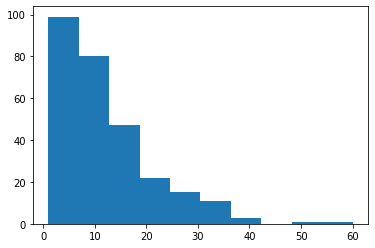

In [14]:
import matplotlib.pyplot as plt
# Plot distribution of n_stops
plt.hist(routes[:,1])

In [95]:
list(range(0,-1,-1))

[0]

In [42]:
l = [[[RouteLabel(1,1,0,1,TargetLabel(p_t, tau_0),1)] for _ in range(2)]]
l.append(l[-1].copy())
l[1][0].remove(l[1][0][0])
l

[[[], [<__main__.RouteLabel at 0x7fd99af341d0>]],
 [[], [<__main__.RouteLabel at 0x7fd99af341d0>]]]

In [49]:
l = list(range(6))
ret = l.remove(2)
print(ret)
l

None


[0, 1, 3, 4, 5]

In [14]:
B = [RouteLabel(1,1,0,0,TargetLabel(p_t, tau_0),0.8), RouteLabel(1,1,0,1,TargetLabel(p_t, tau_0),1)]
B[0].update_stop(0)
B[1].update_stop(0)
for l in B:
    l.pprint()

<class '__main__.RouteLabel'> Departure at 2020-05-11T08:00 from stop 0.
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:10 from stop 0.


In [15]:
label = RouteLabel(4,0, 2, 0, TargetLabel(p_t, tau_0), 0.9)
label.update_stop(0)
label.pprint()
print(update_bag(B, label, 0))
label.stop = 555
for l in B:
    l.pprint()
print('-'*10)
label.pprint()

<class '__main__.RouteLabel'> Departure at 2020-05-11T08:20 from stop 0.
True
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:10 from stop 0.
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:20 from stop 555.
----------
<class '__main__.RouteLabel'> Departure at 2020-05-11T08:20 from stop 555.


In [27]:
bags = [[1,2,3]]
bags.append(bags[-1].copy())
bags[1][2] = 666
bags

[[1, 2, 3], [1, 2, 666]]

In [ ]:
p_s = 0 # start stop = A
p_t = 4 # target stop = E
tau_0 = np.datetime64('2020-05-11T08:05') # departure time 08:05
k_max = 10 # we set a maximum number of transports to pre-allocate memory for the numpy array tau_i

In [ ]:
# initialization
n_stops = len(stops)

# earliest arrival time at each stop for each round.
tau = np.full(shape=(k_max, n_stops), fill_value = np.datetime64('2100-01-01T00:00')) # 2100 instead of infinity # number of stops * max number of transports

# earliest arrival time at each stop, indep. of round
tau_star = np.full(shape=n_stops, fill_value = np.datetime64('2100-01-01T00:00'))

marked = [p_s]
q = []
tau[0, p_s] = tau_0

In [ ]:
np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0]

In [ ]:
routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i

In [ ]:
p_i

In [ ]:
t_r_dep = stopTimes[routes[r][3]+\
                     # offset corresponding to stop p_i in route r
                     np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0] + \
                     routes[r][1]*t_r][1]

In [ ]:
if np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2) <\
np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 3):
    print("hello")

In [ ]:
routeStops[routes[1][2] + np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2)[0][0]:routes[1][2]+routes[1][1]]

In [ ]:
routeStops[routes[1][2] + np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2)[0][0]:6]

In [ ]:
routeStops[routes[1][2]]

In [ ]:
routeStops[np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 2)[0][0]]

In [ ]:
if True and \
        True:
    print("hello")

In [ ]:
tau[0][0]

In [ ]:
stopTimes[3][1]

In [ ]:
a = np.arange(1, 10)
a

In [ ]:
a[1:10:2]

In [ ]:
stopTimes[routes[0][3]+\
          # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[0][2]:routes[0][2]+routes[0][1]] == 0)[0][0]:\
         # end of the trips of r
         routes[0][3]+routes[0][0]*routes[0][1]:\
          # we can jump from the number of stops in r to find the next departure of route r at p_i
         routes[0][1]
         ]
# we may more simply loop through all trips, and stop as soon as the departure time is after the arrival time


In [ ]:
stopTimes[routes[0][3]+\
          # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[0][2]:routes[0][2]+routes[0][1]] == 0)[0][0]][1]

In [ ]:
stopTimes[routes[1][3]+\
          # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[1][2]:routes[1][2]+routes[1][1]] == 3)[0][0] + \
         routes[1][1]*1][1]

In [ ]:
# t_r is a trip that belongs to route r. t_r can take value 0 to routes[r][0]-1
t = None
r = 1
tau_k_1 = tau[0][0]
p_i = 3

t_r = 0
while True:
    
    t_r_dep = stopTimes[routes[r][3]+\
         # offset corresponding to stop p_i in route r
         np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0] + \
         routes[r][1]*t_r][1]
    
    if t_r_dep > tau_k_1:
        # retrieving the index of the departure time of the trip in stopTimes
        #t = routes[r][3] + t_r * routes[r][1]
        t = t_r
        break
    t_r += 1
    # we could not hop on any trip at this stop
    if t_r == routes[r][0]:
        break
        
print("done")
print(t)

In [ ]:
r = 1
t = 1
p_i = 2
# 1st trip of route + offset for the right trip + offset for the right stop
stopTimes[routes[r][3] + t * routes[r][1] + np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)]

In [ ]:
d = []
not d

In [ ]:
r = 1
t = 0
p_i = 4
arr_t_p_i = stopTimes[routes[r][3] + \
                          t * routes[r][1] + \
                          np.where(routeStops[routes[r][2]:routes[r][2]+routes[r][1]] == p_i)[0][0]][0]
arr_t_p_i

In [ ]:
np.datetime64('NaT') > np.datetime64('2100-01-01')

In [ ]:
np.datetime64('NaT') < np.datetime64('2100-01-01')